In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [36]:
from sklearn.feature_extraction.text import CountVectorizer

bag_of_words = CountVectorizer()
bag_of_words.fit(["oi meu nome é carlos"])
bag_of_words.vocabulary_

{'oi': 3, 'meu': 1, 'nome': 2, 'carlos': 0}

In [37]:
result = bag_of_words.transform(["meu meu carlos"])
print(bag_of_words.get_feature_names_out())
print(result.toarray())

['carlos' 'meu' 'nome' 'oi']
[[1 2 0 0]]


In [41]:
import os

pre_file_path = os.path.join('pre_normalized', 'news.csv')
pre_df = pd.read_csv(pre_file_path)
pre_df = pre_df[["text","label"]]
pre_df

,text,label
0,autor bestseller cita 5 expressoes indicam int...,fake
1,juiz df confirma indicios expresidente petista...,fake
2,senhora 60 anos corre atras eduardo cunha aero...,fake
3,russia ameaca derrubar avioes americanos siria...,fake
4,governo podera demitir 18 mil servidores banco...,fake
...,...,...
7195,petistas intervencao serve contornar dificulda...,true
7196,tercafeira 11 julho 2017 boa noite aqui princi...,true
7197,dona marisa exprimeiradama morre sp mulher lul...,true
7198,thiago blumenthal texto agradecimento nobel li...,true


In [42]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(pre_df["text"], pre_df["label"], shuffle= True, test_size=0.2)

In [44]:
bag_of_words = CountVectorizer()
bag_of_words.fit(X_train)

CountVectorizer()

In [45]:
list(bag_of_words.vocabulary_.items())[:10]

[('agora', 2663),
 ('fita', 19833),
 ('pericia', 31689),
 ('vale', 42002),
 ('diz', 15182),
 ('gilmar', 21086),
 ('ironizando', 24515),
 ('audios', 5494),
 ('jbs', 24815),
 ('herman', 21941)]

In [46]:
X_train = bag_of_words.transform(X_train).toarray()
X_test = bag_of_words.transform(X_test).toarray()

In [47]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

GNB = GaussianNB()
BNB = BernoulliNB()
MNB = MultinomialNB()


naive_bayes = [GNB, BNB, MNB]
naive_bayes_names = ["GNB", "BNB", "MNB"]

In [48]:
from sklearn.model_selection import cross_val_score

for i, algo in enumerate(naive_bayes):
    acc = cross_val_score(algo, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{algo} mean accuracy: ", end = "")
    print(round(np.mean(acc), 3))

GaussianNB() mean accuracy: 0.721
BernoulliNB() mean accuracy: 0.878
MultinomialNB() mean accuracy: 0.869


In [49]:
from collections import defaultdict
scores = defaultdict(list)

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

for algo in naive_bayes:
    algo.fit(X_train, y_train)
    y_predict = algo.predict(X_test)

    scores["accuracy"].append(accuracy_score(y_test, y_predict))
    scores["precision"].append(precision_score(y_test, y_predict, pos_label = 'fake'))
    scores["recall"].append(recall_score(y_test, y_predict, pos_label = 'fake'))
    scores["f1_score"].append(f1_score(y_test, y_predict, pos_label = 'fake'))

naive_results_df = pd.DataFrame(scores, index = naive_bayes_names)
naive_results_df

,accuracy,precision,recall,f1_score
GNB,0.706944,0.702346,0.686246,0.694203
BNB,0.860417,0.849508,0.865330,0.857346
MNB,0.845833,0.837110,0.846705,0.841880


In [50]:
# from sklearn.model_selection import GridSearchCV

# num_target_classes = 2

# params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0],
#           'fit_prior': [True, False],
#           'class_prior': [None, [0.1,]* num_target_classes, ],
#           'binarize': [None, 0.0, 8.5, 10.0]
#          }

# bernoulli_nb_grid = GridSearchCV(BernoulliNB(), param_grid=params, n_jobs=-1, cv=5)
# bernoulli_nb_grid.fit(X_train,y_train)
# bernoulli_nb_grid.best_params_

In [51]:
# best_acc_model_param = bernoulli_nb_grid.best_params_
best_bernoulli_param = {'alpha': 0.01, 'binarize': 0.0, 'class_prior': None, 'fit_prior': True}
best_bernoulli = BernoulliNB(**best_bernoulli_param)

#{'alpha': 0.01, 'binarize': 0.0, 'class_prior': None, 'fit_prior': True}

In [52]:
best_bernoulli.fit(X_train, y_train)
y_predict = best_bernoulli.predict(X_test)

acc = accuracy_score(y_test, y_predict)
prec = precision_score(y_test, y_predict, pos_label = 'fake')
recall = recall_score(y_test, y_predict, pos_label = 'fake')
f1_score = f1_score(y_test, y_predict, pos_label = 'fake')

naive_results_df.loc["Tuned BNB"] = [acc, prec, recall, f1_score]
naive_results_df

,accuracy,precision,recall,f1_score
GNB,0.706944,0.702346,0.686246,0.694203
BNB,0.860417,0.849508,0.865330,0.857346
MNB,0.845833,0.837110,0.846705,0.841880
Tuned BNB,0.832639,0.822285,0.835244,0.828714


[]

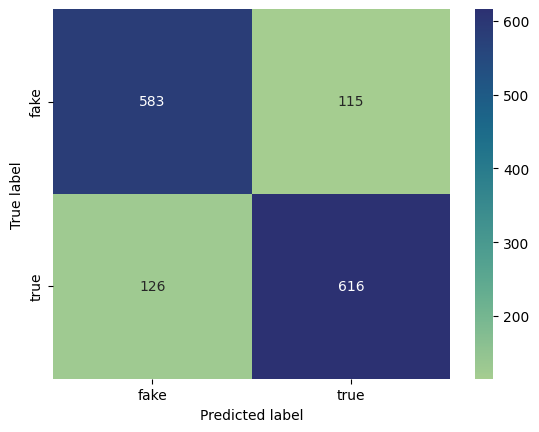

In [53]:
from sklearn.metrics import confusion_matrix

labels = ["fake","true"]
s = sns.heatmap(confusion_matrix(y_test,y_predict),annot=True,fmt="g", xticklabels=labels, yticklabels=labels, cmap="crest")
s.set_xlabel("Predicted label")
s.set_ylabel("True label")
s.plot()